# **APR Project: Speech Emotion Recognition**

*   **Author:** Matteo Onger
*   **Date:** April 2024

**Dataset documentation**:
*   [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D?tab=readme-ov-file)

**Documentation of audio processing libraries**:
*   [Librosa](https://librosa.org/doc/0.10.1/index.html)
*   [PyAudioAnalysis](https://github.com/tyiannak/pyAudioAnalysis)

**Notes**:
* For fast execution, it is necessary to use a gpu-equipped runtime.

In [24]:
# ---- CLONE DATASET ----
!git lfs clone https://github.com/CheyneyComputerScience/CREMA-D.git

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
fatal: destination path 'CREMA-D' already exists and is not an empty directory.
Error(s) during clone:
git clone failed: exit status 128


In [25]:
# ---- LIBRARIES ----
import datetime
import itertools
import librosa
import logging
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import time
import typing

from abc import ABC, abstractmethod
from dataclasses import dataclass
from enum import Enum
from keras import (models, layers)
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (KFold, train_test_split)
from tensorflow.python.keras.callbacks import (EarlyStopping, History, ReduceLROnPlateau)


# ---- INIT PROCEDURES ----
# Init logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [43]:
# ---- PARAMETERS ----
# Maximum allowed duration of the audio track (in seconds)
FIXED_DURATION = 4
# Discard the first few seconds of the signal (in seconds)
FIXED_OFFSET = 0.5

# Number of samples in each short-term frame
# Should be a power of 2 for efficency reasons
STF_LEN = 2048
# Number of overlapping samples in each short-term frame
STF_OVR = 512

# Number of Mel-frequency cepstral coefficients computed per frame
N_MFCC = 20

# Set a fixed random seed to replicate the split between the training set and the test set
RAND_SEED = 2106020002
# Size of the test set in % [0.0, 1.0)
TEST_SIZE = 0.2
# Number of folds
K_FOLDS = 5
# Number of epochs used by predictors
EPOCHS = 50
# Size of the batch used by predictors
BATCH_SIZE = 64


# ---- FILES PATH ----
dirpath = '/content/CREMA-D/AudioWAV'

In [27]:
# ---- ENUMS ----
@dataclass
class EmotionDataMixin:
  """
  Fields of the enumeration of all the emotions considered.
  """
  id: int
  """
  Unique emotion's ID.
  """
  nm: str
  """
  Emotion's name.
  """

class Emotion(EmotionDataMixin, Enum):
  """
  Enumeration of all the emotions considered.
  """
  ANG = 0, 'ANGER'
  DIS = 1, 'DISGUST'
  FEA = 2, 'FEAR'
  HAP = 3, 'HAPPY'
  NEU = 4, 'NEUTRAL'
  SAD = 5, 'SAD'

In [28]:
# ---- UTILITY FUNCS ----
def get_label(filename :str) -> typing.Tuple[int, Emotion]:
  """
  Given a ``filename``, extract the actor ID and the expected emotion according to the convention used by the dataset CREMA-D.
  It can raise ``ValueError``.

  Parameters
  ----------
  ``filename``: string
    Name of the file to analize.

  Return
  ----------
  Return a tuple ``(actorId, emotion)`` that contains the actor id and the emotion.
  """
  found = re.search('.*([0-9]{4})[_][A-Z]{3}[_]([A-Z]{3})[_][A-Z]{2}[.][w][a][v]', filename)
  if found == None or (not(found[2] in [emo.name for emo in Emotion])):
    raise ValueError(f'Unable to extract acotr\'s ID and/or emotion from the given fileanme: {filename}.')
  else:
    actid, emo = int(found[1]), Emotion[found[2]]
  return actid, emo


def get_now() -> str:
  """
  Return a string that represents the timestamp of now().
  """
  return '_' + str(datetime.datetime.now())


def plot_confusion_matrix(cm :np.ndarray, classes :np.ndarray, normalize :bool=False, title :str='Confusion matrix') -> None:
    """
    Function used to plot the confusion matrix ``cm``.

    Parameters
    ----------
    ``cm``:  np.ndarray of shape (n_classes, n_classes)
      Confusion matrix to visualize.
    ``classes``:  np.ndarray of shape (n_classes)
      List of all possible labels.
    ``normalize``:  boolean
      True if data must be normalized.
    ``title``:  string
      Title of the plot.
    """
    plt.imshow(cm, interpolation='nearest', cmap=mpl.colormaps['Blues'])
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment='center',
            color="white" if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_dataframe(name :str, df :pd.DataFrame) -> None:
  """
  Function used to plot the composition of the given dataframe.

  Parameters
  ----------
  ``name``: string
    Name of the dataframe to plot.
  ``df``: pd.DataFrame
    Dataframe to plot.
  """
  # Dictionary to contain number of tracks per emotion
  dct = {j.name:0 for j in Emotion}

  for emo in Emotion:
    dct[emo.name] = len(df[df['Emotion'] == emo.name])

  # Plot the result
  plt.bar(
      list(dct.keys()),
      list(dct.values()),
      width=0.5
  )

  plt.title(f'{name} - Audio Tracks by Emotion')
  plt.xlabel('Emotions')
  plt.ylabel('Number of occurrences')
  plt.show()
  return


def plot_history(history :History) -> None:
  """
  Function used to plot the history of the traning procedure.

  Parameters
  ----------
  ``history``: History
    History of the traning.
  """
  train_acc = history.history['acc']
  train_loss = history.history['loss']
  test_acc = history.history['val_acc']
  test_loss = history.history['val_loss']

  fig , ax = plt.subplots(1,2)
  fig.set_size_inches(14,6)

  ax[0].plot(train_loss, label = 'Training Loss')
  ax[0].plot(test_loss , label = 'Testing Loss')
  ax[0].set_title('Training & Testing Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(train_acc, label = 'Training Accuracy')
  ax[1].plot(test_acc , label = 'Testing Accuracy')
  ax[1].set_title('Training & Testing Accuracy')
  ax[1].legend()
  ax[1].set_xlabel('Epochs')

  plt.show()
  return


def read_signal(fp :str|None=None, x :np.ndarray|None=None, sf :float|None=None) -> typing.Tuple[float, np.ndarray]:
  """
  If the filepath ``fp`` is given, the signal is loaded from the file,
  otherwise the signal ``x`` and the sampling frequency ``sf`` must be explicity given.
  If all the parameters are set, only the filepath is considered; if all the paremeters are ``None``, it raises ``ValueError``.

  Global parameters ``FIXED_DURATION`` and ``FIXED_OFFSET`` are used.

  Parameters
  ----------
  ``fp``: string or None
    Filepath of the audio file.
  ``x``: np.ndarray of shape (n) or None
    Signal to be processed.
  ``sf``: float or None
    Sampling frequency of ``x``.

  Return
  ----------
  Return a tuple ``(freq, x)`` that contains the sampling frequency and the signal.
  """
  if fp is not None:
    x, sf = librosa.load(fp, sr=None, duration=FIXED_DURATION, offset=FIXED_OFFSET, dtype=np.float32)
  if x is None or sf is None:
    raise ValueError('Either `fp` or (`x` and `sf`) must be input.')
  if fp is None:
    x = np.array(x, dtype=np.float32)

  return sf, librosa.util.fix_length(x, size=math.ceil(sf*(FIXED_DURATION-FIXED_OFFSET)))


def read_pickle(fp :str) -> typing.Any:
  """
  Read the file and return the object read.

  Parameters
  ----------
  ``fp``: string
    Filepath of the file.

  Return
  ----------
  Return the object read.
  """
  f = open(fp, 'rb')
  obj = pickle.load(f)
  f.close()
  return obj


def write_pickle(obj :typing.Any, fp :str) -> None:
  """
  Write the object ``obj`` into the file ``fp``.

  Parameters
  ----------
  ``fp``: string
    Filepath of the file, extension is assumed to be '.pickle'.
  ``obj``: Any
    Object to save.
  """
  with open(fp+'.pickle', 'wb') as handle:
    pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
  return

In [29]:
# ---- DATA AUGMENTATION FUNCS ----
def add_noise(x :np.ndarray, rate :float=0.02, const :bool=True) -> np.ndarray:
  """
  Add noise to the signal ``x`` using a normal distribution.

  Parameters
  ----------
  ``x``: np.ndarray of shape (n)
    Signal to be processed.
  ``rate``: float
    Rate of added noise.
  ``const``: bool
    If ``False``, the rate is choosen randomly between ``rate``*[0.0, 1.0).

  Return
  ----------
  Return the changed signal.
  """
  if not const:
    rate *= np.random.random()
  noise = np.random.uniform() * rate * np.max(x)
  x += np.random.normal(size=x.size) * noise
  return x


def shift_pitch(x :np.ndarray, sf :float, fact :float=0.5, const :bool=True) -> np.ndarray:
  """
  Change the pitch of the signal ``x``.

  Parameters
  ----------
  ``x``: np.ndarray of shape (n)
    Signal to be processed.
  ``sf``: float
    Sampling frequency of ``x``.
  ``fact``: float
    Factor of the shift.
  ``const``: bool
    If ``False``, the factor is choosen randomly between ``fact``*[0.0, 1.0).

  Return
  ----------
  Return the changed signal.
  """
  if not const:
    fact *= np.random.random()
  x = librosa.effects.pitch_shift(y=x, sr=sf, n_steps=fact)
  return x

In [30]:
# ---- FEATURE EXTRACTION FUNCS ----
def mfcc(fp :str|None=None, x :np.ndarray|None=None, sf :float|None=None) -> np.ndarray:
  """
  Read the signal using ``read_signal(fp, x, sf)`` and compute the Mel-frequency cepstral coefficients.
  The number of coefficients, the size of each frame and the overlapping percentage are defined as global parameters.

  Parameters
  ----------
  ``fp``: string or None
    Filepath of the audio file.
  ``x``: np.ndarray of shape (n) or None
    Signal to be processed.
  ``sf``: float or None
    Sampling frequency of ``x``.

  Return
  ----------
  Return the Mel-frequency cepstral coefficients.
  """
  sf, x = read_signal(fp, x, sf)
  # Trasposed array -> one row per frame and one col per coeff
  coeff = librosa.feature.mfcc(y=x, sr=sf,  n_mfcc=N_MFCC, n_fft=STF_LEN, hop_length=STF_OVR).T
  # Ravel to get a one-dimensional array
  return np.ravel(coeff)


def rms(fp :str|None=None, x :np.ndarray|None=None, sf :float|None=None) -> np.ndarray:
  """
  Read the signal using ``read_signal(fp, x, sf)`` and compute the root-mean-square value for each frame.
  The size of each frame and the overlapping percentage are defined as global parameters.

  Parameters
  ----------
  ``fp``: string or None
    Filepath of the audio file.
  ``x``: np.ndarray of shape (n) or None
    Signal to be processed.
  ``sf``: float or None
    Sampling frequency of ``x``.

  Return
  ----------
  Return the root-mean-square value for each frame.
  """
  sf, x = read_signal(fp, x, sf)
  vals = librosa.feature.rms(y=x, frame_length=STF_LEN, hop_length=STF_OVR)
  # Squeeze to get a one-dimensional array
  return np.squeeze(vals)


def zcr(fp :str|None=None, x :np.ndarray|None=None, sf :float|None=None) -> np.ndarray:
  """
  Read the signal using ``read_signal(fp, x, sf)`` and compute the zero-crossing rate for each frame.
  The size of each frame and the overlapping percentage are defined as global parameters.

  Parameters
  ----------
  ``fp``: string or None
    Filepath of the audio file.
  ``x``: np.ndarray of shape (n) or None
    Signal to be processed.
  ``sf``: float or None
    Sampling frequency of ``x``.

  Return
  ----------
  Return the zero-crossing rate per frame.
  """
  sf, x = read_signal(fp, x, sf)
  vals = librosa.feature.zero_crossing_rate(y=x, frame_length=STF_LEN, hop_length=STF_OVR)
  # Squeeze to get a one-dimensional array
  return np.squeeze(vals)


# Call all previously defined feature extraction functions
def extract_features_from_signal(fp :str|None=None, x :np.ndarray|None=None, sf :float|None=None) -> np.ndarray:
  """
  This function calls all previously defined feature extraction functions, that are: ``mfcc``, ``rms`` and ``zcr``.

  Parameters
  ----------
  ``fp``: string or None
    Filepath of the audio file.
  ``x``: np.ndarray of shape (n) or None
    Signal to be processed.
  ``sf``: float or None
    Sampling frequency of ``x``.

  Return
  ----------
  Return a single 1D vector that contains all the features computed.
  """
  feats = np.hstack((
                    mfcc(fp, x, sf),
                    rms(fp, x, sf),
                    zcr(fp, x, sf),
  ))
  return feats


# Feature extraction from given dataframe using previously defined feature extraction functions
def extract_features_from_dataset(df :pd.DataFrame, noise :bool=True, pitch :bool=True, noiseAndPitch :bool=True, csvpath :str|None=None) -> typing.Tuple[np.ndarray, np.ndarray]:
  """
  Given a dataframe ``df`` with at least the columns ``Speech``, which contains the paths to the audio tracks, and
  ``Emotion``, which contains the labels, it computes an array of features for each signal using the function ``extract_features_from_signal``.
  Depending on the flags set, data augmentation techniques are applied to produce new datapoints used during the training phase.
  If ``csvpath`` is not None, results are saved to the given file using the csv standard.

  Parameters
  ----------
  ``df``: pd.DataFrame
    Dataframe to process.
  ``noise``: bool
    If ``True``, the function ``add_noise`` is used to generate a new datapoint for each track.
  ``pitch``: bool
    If ``True``, the function ``shift_pitch`` is used to generate a new datapoint for each track.
  ``noiseAndPitch``: bool
    If ``True``, the functions ``noise`` and ``shift_pitch`` are used to generate a new datapoint for each track.
  ``csvpath``: string or None
    Filepath to store the computed result.

  Return
  ----------
  Return a tuple (``X``, ``Y``).
  ``X``, np.ndarry with shape (num_of_datapoints, num_of_feats), contains the features for each track,
  while ``Y``, np.ndarry with shape (num_of_datapoints), contains the labels.
  """
  # Features dataset of the tracks and respective labels
  X, Y = [], []

  # Measure progress
  start = time.time()
  logger.info(f'Extract_features_from_dataset -> START')
  progress, nRows = 0, len(df)

  # For each audio file
  for _, row in df.iterrows():
    sf, x = read_signal(row['Speech'])

    progress += 1
    if progress % 250 == 0:
      end = time.time()
      logger.info(f'Processed {progress} files over {nRows} in {round(end-start, 2)} seconds.')

    # Compute the feats of the original signal
    feats = extract_features_from_signal(x=x, sf=sf)
    X.append(feats)
    Y.append(Emotion[row['Emotion']].value[0])

    # Compute the feats for the original signal + noise
    xn = add_noise(x=x, const=False)
    feats = extract_features_from_signal(x=xn, sf=sf)
    X.append(feats)
    Y.append(Emotion[row['Emotion']].value[0])

    # Compute the feats for the original signal + pithcing
    xp = shift_pitch(x=x, sf=sf, const=False)
    feats = extract_features_from_signal(x=xp, sf=sf)
    X.append(feats)
    Y.append(Emotion[row['Emotion']].value[0])

    # Compute the feats for the original signal + noise + pithcing
    xn = add_noise(x=x, const=False)
    xnp = shift_pitch(x=xn, sf=sf, const=False)
    feats = extract_features_from_signal(x=xnp, sf=sf)
    X.append(feats)
    Y.append(Emotion[row['Emotion']].value[0])

  # Write computed data
  if csvpath is not None:
    result = pd.DataFrame(X)
    result['Label'] = Y
    result.to_csv(csvpath, index=False)

  logger.info(f'Extract_features_from_dataset -> DONE')
  return np.array(X), np.array(Y)

In [31]:
# ---- NORMALIZATION FUNCS ----
def standardize(a :np.ndarray, b :np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray]:
  """
  Using ``sklearn.preprocessing.StandardScaler``, it fits and transforms the data ``a`` and then transforms data ``b``.

  Parameters
  ----------
  ``a``: np.ndarray
    Data used to fit and then standardized.
  ``b``: np.ndarray
    Data to standardize.

  Return
  ----------
  Return the given data standardized.
  """
  s = StandardScaler()
  a = s.fit_transform(a)
  b = s.transform(b)
  return a, b

In [32]:
# ---- PREDICTOR CLASSES ----
# Abstract class for NNs
class NeuralNetwork(ABC):
  @abstractmethod
  def fit(self, trainX, trainY, valX, valY) -> History:
    """
    Fit the model.

    Parameters
    ----------
    ``trainX``:
      Dataset used to train the model.
    ``trainY``:
      Expected labels of the dataset ``trainX``.
    ``valX``:
      Dataset used to validate the model.
    ``valY``:
      Expected labels of the dataset ``valX``.

    Return
    ----------
    Return the history of the traning procedure.
    """
    pass

  @abstractmethod
  def predict(self, testX):
    """
    Predict the labels of the datapoints in ``testX``.

    Parameters
    ----------
    ``testX``:
      Datapoints to process.

    Return
    ----------
    Return the predicted labels ``testY`` for ``testX``.
    """
    pass


# One-dimentional convolutional neural networks
class CNN1Dv1(NeuralNetwork):
  """
  This class implements a one-dimensional convolutional neural network with 19 layers:
  See the body of the constructor to get more info about the specific structure.
  """
  def __init__(self,
               inputShape :typing.Tuple[int, ...],
               outputShape :int,
               name :str='CNN1Dv1'):
    """
    Create a new predictor ready to be trained.

    Parameters
    ----------
    ``inputShape``: tuple of int
      Shape of the datapoint to process.
    ``outputShape``: int
      Shape of the output (one-dimensional).
    ``name``: string
      Name of the model.

    Return
    ----------
    Return a new model ready to be trained.
    """
    self.name = name

    # Callbacks used during the traning
    self.earlyStopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True, verbose=1)
    self.lrReduction = ReduceLROnPlateau(monitor='val_acc', patience=5, factor=0.2, verbose=1)

    # Model
    self.model = models.Sequential([
        layers.Conv1D(filters=512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=inputShape),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=5, strides=2, padding="same"),

        layers.Conv1D(filters=512, kernel_size=5, strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=5, strides=2, padding="same"),

        layers.Conv1D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=5, strides=2, padding="same"),

        layers.Conv1D(filters=256, kernel_size=5-2, strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=5, strides=2, padding="same"),

        layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=5, strides=2, padding="same"),

        layers.Flatten(),
        layers.Dense(units=512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(units=outputShape, activation="softmax")
    ])

    self.model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])
    self.model.summary()
    return

  # METHODS
  def fit(self, trainX :np.ndarray, trainY :np.ndarray, valX :np.ndarray, valY :np.ndarray) -> History:
    history = self.model.fit(trainX, trainY, validation_data=(valX, valY),
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   callbacks=[self.earlyStopping, self.lrReduction])
    return history

  def predict(self, testX :np.ndarray) -> np.ndarray:
    return self.model.predict(testX)


class CNN1Dv2(NeuralNetwork):
  """
  This class implements a one-dimensional convolutional neural network with 16 layers:
  See the body of the constructor to get more info about the specific structure.

  Wrt ``CNN1Dv1``, far fewer neurons are used due to the smaller size of the ``layers.Conv1D``'s filters.
  In addition a ``layers.Dropout`` has been added.
  """
  def __init__(self,
               inputShape :typing.Tuple[int, ...],
               outputShape :int,
               name :str='CNN1Dv2',
               kernelSize :int=40,
               stridesConv :int=20):
    """
    Create a new predictor ready to be trained.

    Parameters
    ----------
    ``inputShape``: tuple of int
      Shape of the datapoint to process.
    ``outputShape``: int
      Shape of the output (one-dimensional).
    ``name``: string
      Name of the model.
    ``kernelSize``: int
      Size of the kernel used in conv layers.
    ``stridesConv``: int
      Size of the strides used in conv layers.

    Return
    ----------
    Return a  new model ready to be trained.
    """
    self.name = name

    # Callbacks used during the traning
    self.earlyStopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True, verbose=1)
    self.lrReduction = ReduceLROnPlateau(monitor='val_acc', patience=5, factor=0.2, verbose=1)

    # Model
    self.model = models.Sequential([
        layers.Conv1D(filters=64, kernel_size=kernelSize, strides=stridesConv, padding='same', activation='relu', input_shape=inputShape),
        layers.BatchNormalization(),

        layers.Conv1D(filters=64, kernel_size=kernelSize, strides=stridesConv, padding='same', activation='relu', input_shape=inputShape),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=5, strides=2, padding="same"),

        layers.Dropout(0.2),

        layers.Conv1D(filters=32, kernel_size=kernelSize, strides=stridesConv, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=5, strides=2, padding="same"),

        layers.Conv1D(filters=16, kernel_size=kernelSize, strides=stridesConv, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=5, strides=2, padding="same"),

        layers.Flatten(),
        layers.Dense(units=16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(units=outputShape, activation="softmax")
    ])

    self.model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])
    self.model.summary()
    return

  # METHODS
  def fit(self, trainX :np.ndarray, trainY  :np.ndarray, valX  :np.ndarray, valY  :np.ndarray) -> History:
    history = self.model.fit(trainX, trainY, validation_data=(valX, valY),
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE)
    return history

  def predict(self, testX  :np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray]:
    """
    Predict the labels of the datapoints in ``testX``.

    Parameters
    ----------
    ``testX``: np.ndarray
      Datapoints to process.

    Return
    ----------
    Returns two vectors: the first contains the list of predicted emotions,
    the second contains the probability vectors indicating the confidence with which a prediction was made.
    """
    emos = list()
    prob = self.model.predict(testX)

    for v in prob:
      idx = v.argmax()
      emos.append(idx)
    return np.array(emos), prob

In [33]:
# Analyze the duration of the tracks
counter = 0
dMin, dMax, dAvg, dCnt = float('+inf'), float('-inf'), 0.0, 0

# For each audio file
for filename in os.listdir(dirpath):
  filepath = os.path.join(dirpath, filename)
  d = librosa.get_duration(path=filepath)

  # Update vars
  counter += 1
  dAvg += d
  dMin, dMax = min(dMin, d), max(dMax, d)
  dCnt += 1 if d > (FIXED_DURATION + FIXED_OFFSET) else 0

dAvg = dAvg / counter


print('Tracks duration info:')
print(f' - duration of the shortes track: {round(dMin, 2)}')
print(f' - mean duration of the track: {round(dAvg, 2)}')
print(f' - duration of the longest track: {round(dMax, 2)}')
print(f' - number of track length greater than {(FIXED_DURATION + FIXED_OFFSET)} seconds : {dCnt}')

Tracks duration info:
 - duration of the shortes track: 1.27
 - mean duration of the track: 2.54
 - duration of the longest track: 5.0
 - number of track length greater than 4.5 seconds : 20


In [34]:
# Create a dataframe for actors info  [ActorId|Age|Sex|Race|Ethnicity]
actorsDF = pd.read_csv('/content/CREMA-D/VideoDemographics.csv', index_col='ActorID')

# Temporary variables
filepaths = []
actors = []
emotions = []

# For each audio file
for filename in os.listdir(dirpath):
  filepath = os.path.join(dirpath, filename)
  actid, emo = get_label(filename)

  filepaths.append(filepath)
  actors.append(actid)
  emotions.append(emo.name)

# Create a dataframe [index|ActorID|Sex|Speech|Emotion]
df = pd.DataFrame()
df['ActorID'] = actors
df['Sex'] = df['ActorID'].apply(lambda x: actorsDF.loc[x]['Sex'])
df['Speech'] = filepaths
df['Emotion'] = emotions

# Split the dataset according to the gender of the actor
mdf = df[df['Sex'] == 'Male']
fdf = df[df['Sex'] == 'Female']


print('Tracks info:')
print(f' - total number of tracks: {len(df)}')
print(f' - ratio of male actors to female actresses: {math.floor(100*len(mdf)/len(df))}% / {math.ceil(100*len(fdf)/len(df))}%')

Tracks info:
 - total number of tracks: 7442
 - ratio of male actors to female actresses: 52% / 48%


,ActorID,Sex,Speech,Emotion
0,1019,Male,/content/CREMA-D/AudioWAV/1019_TIE_SAD_XX.wav,SAD
1,1045,Male,/content/CREMA-D/AudioWAV/1045_ITH_NEU_XX.wav,NEU
2,1081,Male,/content/CREMA-D/AudioWAV/1081_IEO_DIS_MD.wav,DIS
3,1043,Female,/content/CREMA-D/AudioWAV/1043_MTI_FEA_XX.wav,FEA
4,1075,Female,/content/CREMA-D/AudioWAV/1075_TSI_SAD_XX.wav,SAD
...,...,...,...,...
7437,1086,Male,/content/CREMA-D/AudioWAV/1086_IEO_HAP_LO.wav,HAP
7438,1081,Male,/content/CREMA-D/AudioWAV/1081_DFA_HAP_XX.wav,HAP
7439,1008,Female,/content/CREMA-D/AudioWAV/1008_DFA_DIS_XX.wav,DIS
7440,1072,Female,/content/CREMA-D/AudioWAV/1072_IEO_HAP_LO.wav,HAP


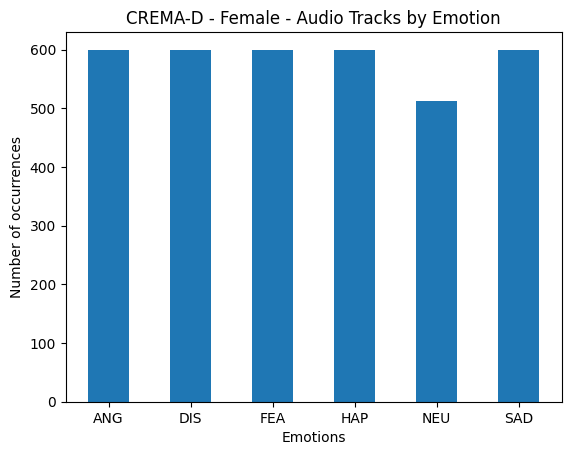

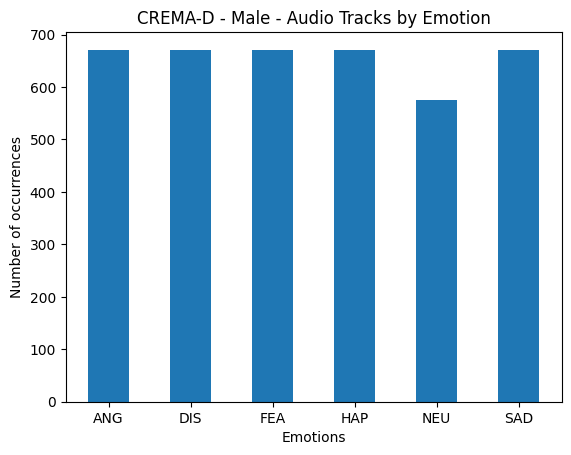

In [35]:
display(df)
plot_dataframe('CREMA-D - Female', fdf)
plot_dataframe('CREMA-D - Male', mdf)

In [36]:
# Extract features from the female dataset (a different dataset, such as mdf or df, can be provided)
X, Y = extract_features_from_dataset(fdf)

# One-hot encoded labels
Y = to_categorical(y=Y, num_classes=len(Emotion))

INFO:root:Extract_features_from_dataset -> START
INFO:root:Processed 250 files over 3512 in 44.21 seconds.
INFO:root:Processed 500 files over 3512 in 90.3 seconds.
INFO:root:Processed 750 files over 3512 in 134.34 seconds.
INFO:root:Processed 1000 files over 3512 in 178.58 seconds.
INFO:root:Processed 1250 files over 3512 in 223.6 seconds.
INFO:root:Processed 1500 files over 3512 in 268.76 seconds.
INFO:root:Processed 1750 files over 3512 in 313.32 seconds.
INFO:root:Processed 2000 files over 3512 in 358.77 seconds.
INFO:root:Processed 2250 files over 3512 in 403.77 seconds.
INFO:root:Processed 2500 files over 3512 in 448.38 seconds.
INFO:root:Processed 2750 files over 3512 in 492.84 seconds.
INFO:root:Processed 3000 files over 3512 in 539.03 seconds.
INFO:root:Processed 3250 files over 3512 in 583.56 seconds.
INFO:root:Processed 3500 files over 3512 in 627.86 seconds.
INFO:root:Extract_features_from_dataset -> DONE


In [37]:
# Split dataset into traning set and test set
trainX, testX, trainY, testY = train_test_split(X, Y, random_state=RAND_SEED, test_size=TEST_SIZE, shuffle=True)
# Standardization of the datasets
trainX, testX = standardize(trainX, testX)


print('Datasets info:')
print(f' - X train shape: {trainX.shape}')
print(f' - Y train shape: {trainY.shape}')
print(f' - X test shape: {testX.shape}')
print(f' - Y test shape: {testY.shape}')

Datasets info:
 - X train shape: (11238, 2420)
 - Y train shape: (11238, 6)
 - X test shape: (2810, 2420)
 - Y test shape: (2810, 6)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 121, 64)           2624      
                                                                 
 batch_normalization_50 (Ba  (None, 121, 64)           256       
 tchNormalization)                                               
                                                                 
 conv1d_41 (Conv1D)          (None, 7, 64)             163904    
                                                                 
 batch_normalization_51 (Ba  (None, 7, 64)             256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_30 (MaxPooli  (None, 4, 64)             0         
 ng1D)                                                           
                                                     

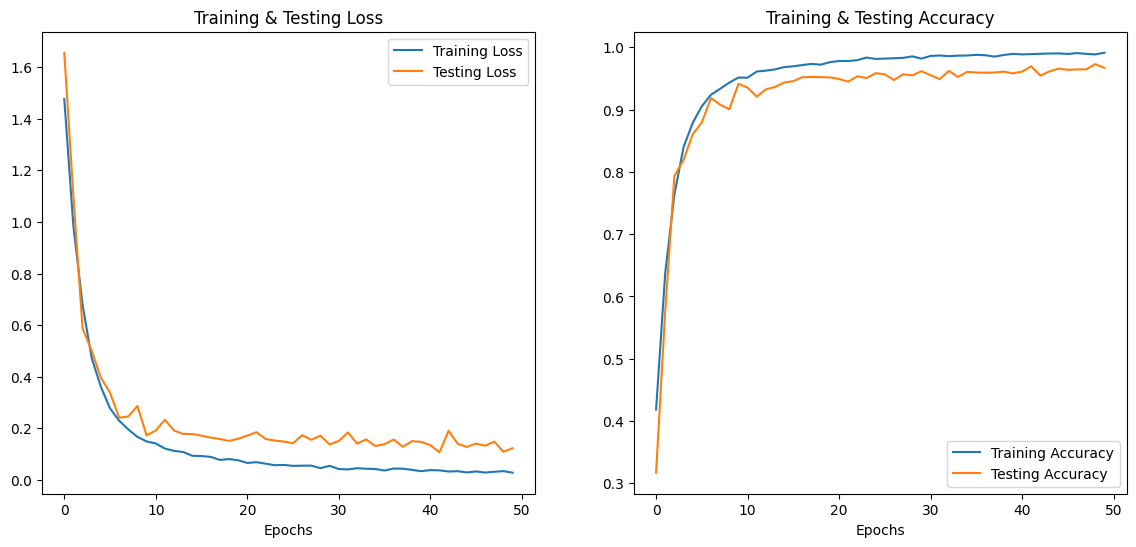

In [38]:
# Create the model
model = CNN1Dv2(inputShape=(trainX.shape[1], 1), outputShape=len(Emotion))

# Train the model
history = model.fit(trainX, trainY, testX, testY)

# Save history for future analysis
write_pickle(history, model.name+get_now())

# Plot accuracy and loss
maxAcc = max(history.history['val_acc'])
print(f'Higher accuracy achieved on the test set: {maxAcc}')
plot_history(history)

88/88 [==============================] - 0s 4ms/step
Confusion matrix, without normalization


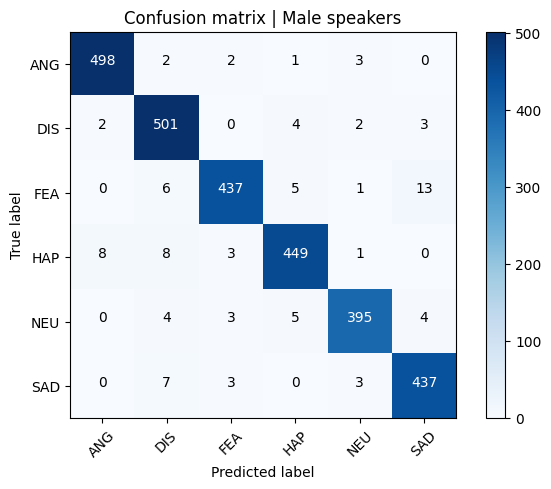

In [39]:
# Predict the labels for data in testX
predY, prob = model.predict(testX)

# Compute and plot the confusion matrix
confmat = confusion_matrix(y_true=testY.argmax(axis=1), y_pred=predY)
plot_confusion_matrix(confmat, np.array([e.name for e in Emotion]), title = 'Confusion matrix | Male speakers')

## Extra code for basic tuning of hyper-parameters

In [ ]:
# K-fold cross validation to find best hyper-params
###hyperparam = [20, 40, 60]
###hpValAcc = [0 for i in range(len(hyperparam))]

# For each possible val of hyper-parameter
###for idx, hp in enumerate(hyperparam):

  # Define the K-fold Cross Validator
  ###kfold = KFold(n_splits=K_FOLDS, shuffle=True)

  # K-fold Cross Validation model evaluation
  ###fold = 1
  ###for trainIdx, valiIdx in kfold.split(trainX, trainY):
    ###print(f'\nHyper-parameter: {hp} - Fold: {fold} -->')
    ###fold += 1

    # Create the model
    ###model = CNN1Dv2(inputShape=(trainX.shape[1], 1), outputShape=len(Emotion), kernelSize=hp)

    # Train the model
    ###history = model.fit(trainX[trainIdx], trainY[trainIdx], trainX[valiIdx], trainY[valiIdx])
    ###hpValAcc[idx] += max(history.history['val_acc'])

  ###hpValAcc[idx] = hpValAcc[idx] / K_FOLDS

###print(f'Accuracy achieved by each model: {hpValAcc}')

## Extra code to read and view history from file

In [41]:
# Read the history
###historyFilepath = ''
###history = read_pickle(historyFilepath)

###plot_history(history)
###maxAcc = max(history.history['val_acc'])
###print(f'Higher accuracy achieved on the test set: {maxAcc}')

In [42]:
###for i, v in enumerate(history.history['val_acc']):
  ###p = round(v, 4)
  ###print(f'({i+1}, {p})')